In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.signal import lombscargle
from statsmodels.tsa.stattools import acf, pacf


def mat_to_pd(mat):
    """load matlab file and select trial variables"""
    mat = loadmat(mat)
    mat = {
        k: v.squeeze()
        for k, v in mat.items()
        if isinstance(v, np.ndarray) and v.shape == mat["RT"].shape
    }
    return pd.DataFrame(mat)


"""
variable descriptions
---------------------
coherence : float
    motion coherence of the trial, between 0-1
correct : 0 or 1
    0 if correct
    1 if error
RT : float
    response time to L/R from stimulus onset
dotDirection : 0 or pi
    direction of the motion, in radians
selectedDuration : float
    duration of the dot display, in seconds
    NaN = unlimited duration
waterSoFar : int
    amount of water consumed from start of session, in a.u.
proposedReward : float
    amount of water rewarded for correct trial, in a.u.
correctionTrial : 0 or 1
    0 if the motion direction was chosen randomly
    1 if the motion direction was the same as the previous failed trial
selectedDotSize : float
    size of dots, in stixels
selectedContrast : float
    constrast of the dots against the background, between 0-1
selectedSpeed : float
    speed of dots, in stixels per frame
proposedPenalty : float
    duration of timeout if error
pctCorrectionTrials : float
    probability of entering correction mode after error, between 0-1
isLoop : 0 or 1
    0 if movie does not loop until response
    1 if movie loops until rat responds
sessionNumber : int
    session is the span of time when rat had access to the game
"""


df195 = mat_to_pd("datasets/Rat195Vectors_241025.mat").assign(rat=195)
df196 = mat_to_pd("datasets/Rat196Vectors_241025.mat").assign(rat=196)
df = (
    pd.concat([df195, df196])
    .query("Valid == 1 and RT == RT")  # remove disqualified trials, and dropna
    .assign(trialDate=lambda x: pd.to_datetime(x["trialDate"] - 719529, unit="D"))
    .set_index("trialDate")
    .sort_index()
    .assign(coherence=lambda x: pd.cut(x["coherence"], bins=15, labels=False))  # discretize
)

df.groupby("rat")["RT"].count()

rat
195    108841
196    132743
Name: RT, dtype: int64

**plot rt by time**

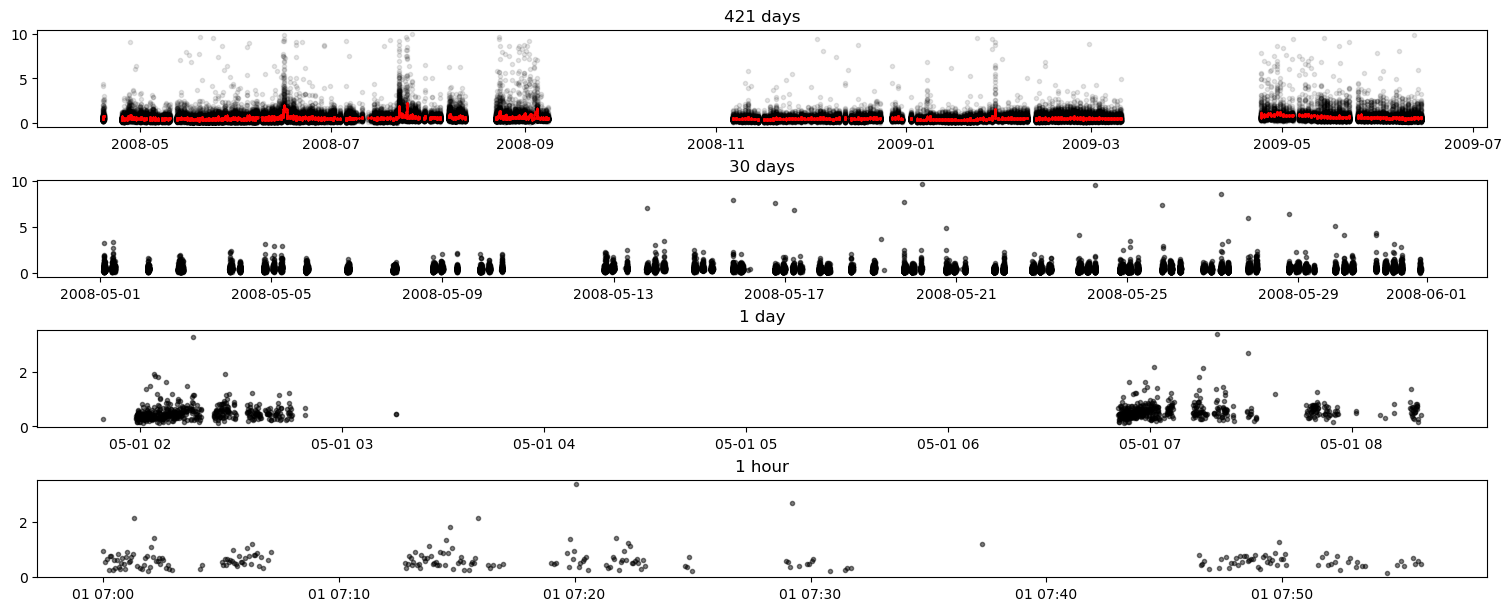

In [2]:
df = df.query("rat == 196")  # select rat 196 (for now)

fig, axs = plt.subplots(nrows=4, figsize=(15, 6), layout="constrained")

axs[0].set_title("421 days")
axs[0].plot(df["RT"], ".", c="k", alpha=0.1)
axs[0].plot(df["RT"].rolling(window=100).agg("mean"), ".", ms=0.5, c="r")

axs[1].set_title("30 days")
axs[1].plot(df.loc["2008-05"]["RT"], ".", c="k", alpha=0.5)

axs[2].set_title("1 day")
axs[2].plot(df.loc["2008-05-01"]["RT"], ".", c="k", alpha=0.5)

axs[3].set_title("1 hour")
axs[3].plot(df.loc["2008-05-01 07"]["RT"], ".", c="k", alpha=0.5)

<Axes: xlabel='Hour', ylabel='Date'>

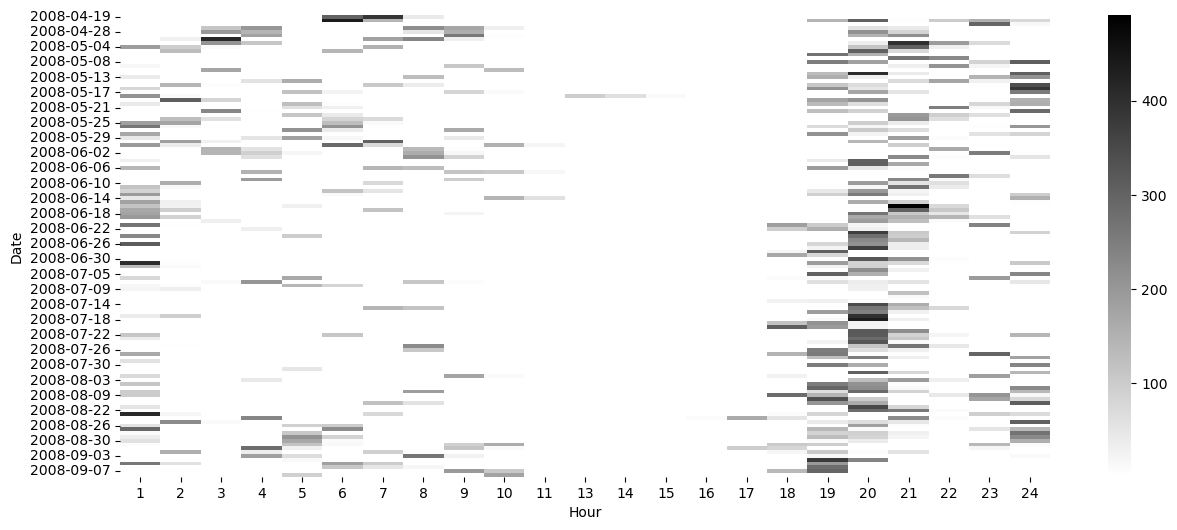

In [3]:
import seaborn as sns

df_heatmap = (
    df.loc["2008-04":"2008-09"]
    .assign(Date=lambda x: x.index.date, Hour=lambda x: x.index.hour + 1)
    .pivot_table(index="Date", columns="Hour", values="RT", aggfunc="count")
)

fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(df_heatmap, cmap="binary", ax=ax)

**plot global vs local autocorrelation**

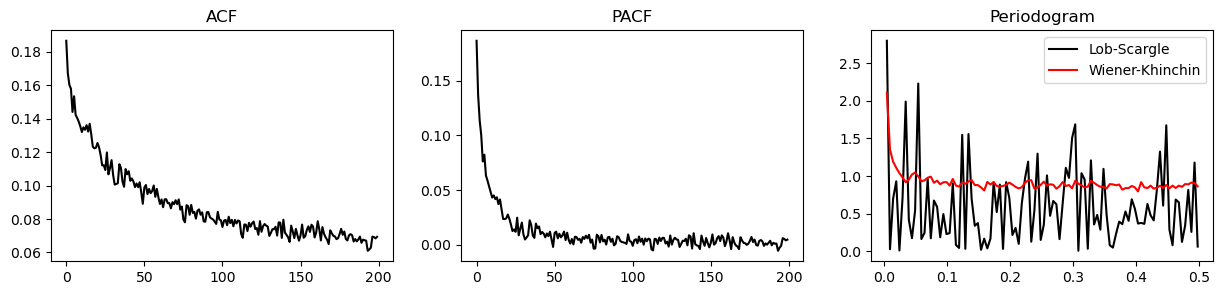

In [4]:
# ACF / PSD
fig, axs = plt.subplots(ncols=3, figsize=(15, 3), sharey=False)

n_lags = 200
acf_kwargs = dict(fft=True, bartlett_confint=False, missing="drop")
acf_ = acf(df["RT"], nlags=n_lags, **acf_kwargs)

freqs = np.fft.fftfreq(n_lags + 1)
mask = freqs > 0
freqs = freqs[mask]
powers_wk = np.fft.fft(acf_).real
powers_wk = powers_wk[mask]

axs[0].set_title("ACF")
axs[0].plot(acf_[1:], c="k")

axs[1].set_title("PACF")
axs[1].plot(pacf(df["RT"], nlags=n_lags)[1:], c="k")

# Lob-Scargle (LS) periodogram
# least squares fit of sine curves
freqs_angular = 2 * np.pi * freqs
powers_ls = lombscargle(x=df.index, y=df["RT"], freqs=freqs_angular)

axs[2].set_title("Periodogram")
axs[2].plot(freqs, powers_ls, c="k", label="Lob-Scargle")
axs[2].plot(freqs, powers_wk, c="r", label="Wiener-Khinchin")
axs[2].legend()

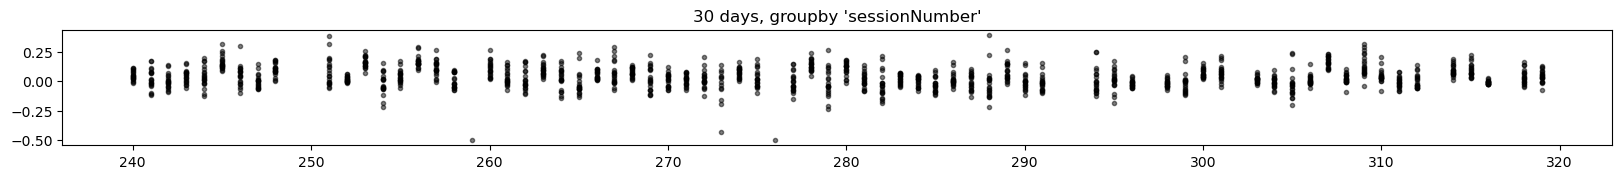

In [5]:
acf_by_session = (
    df.loc["2008-06"]
    .groupby("sessionNumber")["RT"]
    .apply(lambda grp: acf(grp, nlags=20, **acf_kwargs)[1:])
    .explode()
)

fig, ax = plt.subplots(figsize=(20, 6 / 4))
ax.set_title("30 days, groupby 'sessionNumber'")
ax.plot(acf_by_session, ".", c="k", alpha=0.5)

**parameter recovery simulations, minimum sample size**

In [6]:
from joblib import Parallel, delayed

from drift_diffusion.model import DriftDiffusionModel
from drift_diffusion.sim import sample_from_pdf

# parameter recovery simulations, 70K trials
df_subset = df.loc["2008-04":"2008-09"].assign(
    RT=lambda x: x["RT"] - x["RT"].min() + 1e-2, correct=lambda x: x["correct"].map({1: 1, 0: -1})
)
X, y = df_subset["RT"].to_numpy(), df_subset["correct"].to_numpy()

ddm = DriftDiffusionModel(t=0, z=0)
ddm.fit(X, y)
ddm.params_

array([0.81172654, 0.56021281])

In [7]:
params = ddm.params_

n_repeats = 1000
n_samples = [50, 100, 200, 400, 800, 1600]


@delayed
def run_simulation(repeat, n):
    X_, y_ = sample_from_pdf(a=params[0], v=params[1], n_samples=n, random_state=repeat)
    ddm.fit(X_, y_)
    return ddm.params_


def bias_sd_rmse(params, params_):
    """params (true values), params_ (matrix of estimates)"""
    params_mean_ = params_.mean(axis=0)
    bias_ = np.mean(params_ - params, axis=0)
    sd_ = np.sqrt(np.mean((params_ - params_mean_) ** 2, axis=0))
    rmse_ = np.sqrt(np.mean((params_ - params) ** 2, axis=0))
    return bias_, sd_, rmse_


results = {"n": [], "param": [], "bias": [], "sd": [], "rmse": []}

for n in n_samples:

    with Parallel(n_jobs=-2) as parallel:
        params_ = np.asarray(parallel(run_simulation(repeat, n) for repeat in range(n_repeats)))

    bias_, sd_, rmse_ = bias_sd_rmse(params, params_)
    results["n"].extend([n] * len(params))
    results["param"].extend(["a", "v"])
    results["bias"].extend(bias_)
    results["sd"].extend(sd_)
    results["rmse"].extend(rmse_)

params_map = dict(zip(["a", "v"], params))
results = pd.DataFrame(results).assign(
    rel_bias=lambda x: x["bias"] / x["param"].map(params_map),
    rel_sd=lambda x: x["sd"] / x["param"].map(params_map),
    rel_rmse=lambda x: x["rmse"] / x["param"].map(params_map),
)

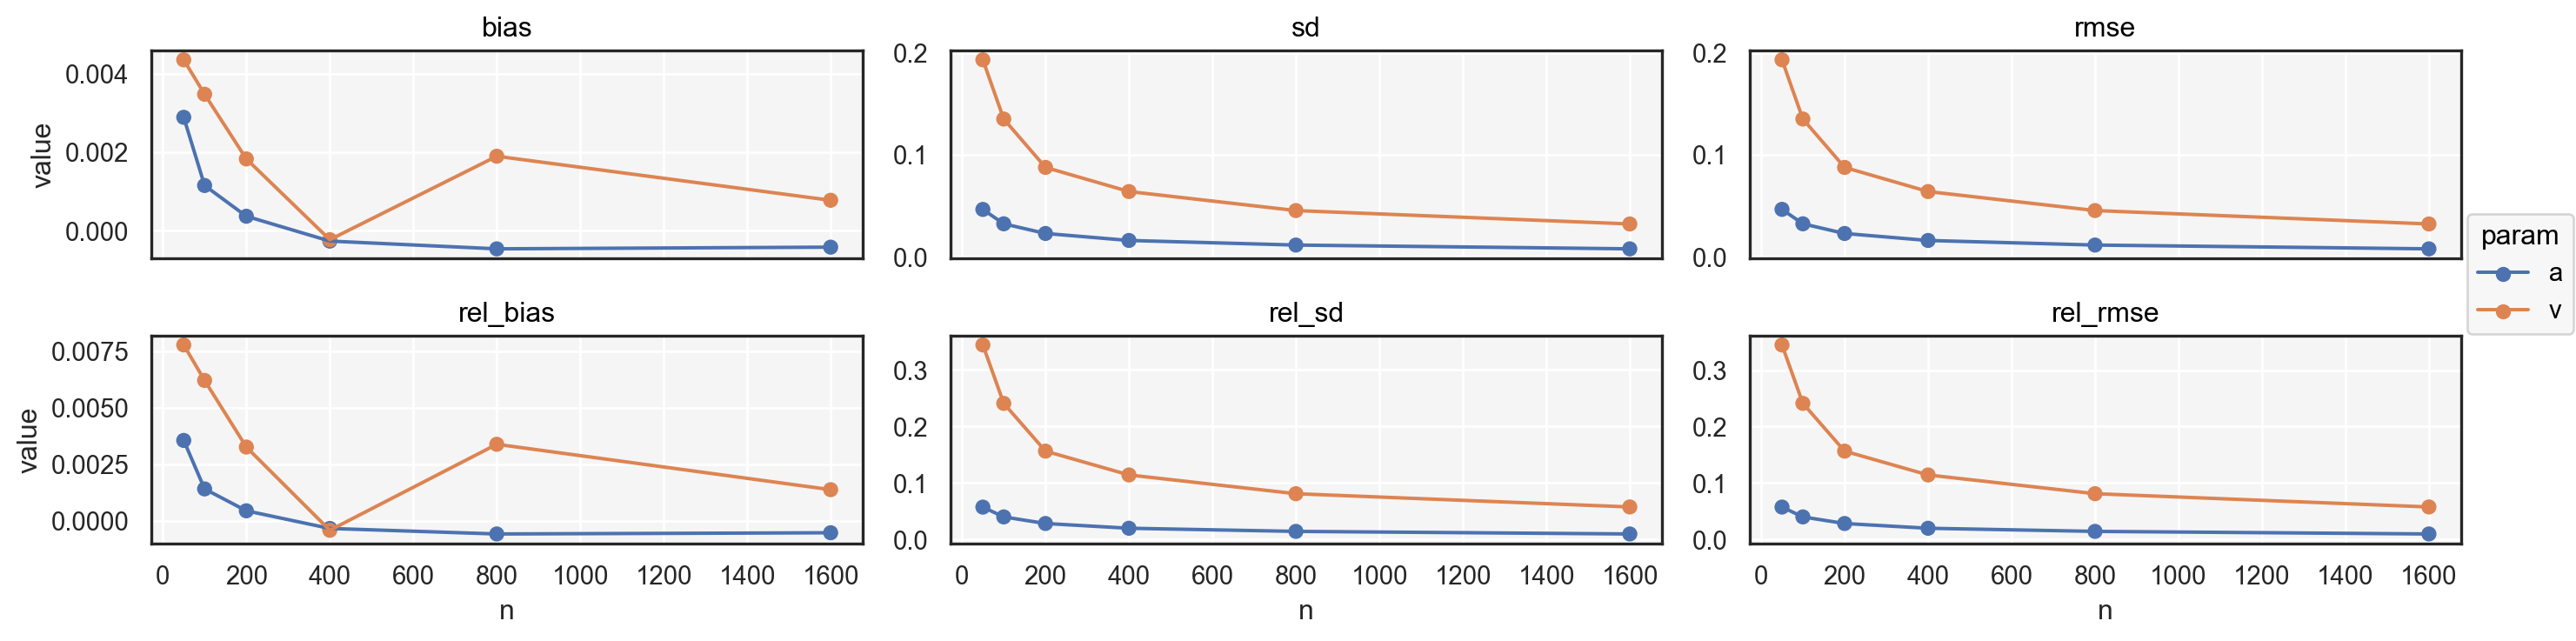

In [8]:
import seaborn.objects as so

(
    so.Plot(results.melt(id_vars=["n", "param"]), x="n", y="value", color="param")
    .facet(col="variable", wrap=3)
    .add(so.Dot())
    .add(so.Line())
    .share(y=False)
    .layout(size=(15, 4))
    .theme({"axes.facecolor": "whitesmoke", "axes.edgecolor": "k"})
)

**fit ddm to rat 196 by day**

In [9]:
ddm = DriftDiffusionModel(t=0, z=0, cov_estimator="sample-hessian")


def fit_ddm(grp):
    if len(grp) < 400:  # see simulations above
        return None

    X = grp["RT"].to_numpy()
    y = grp["correct"].to_numpy()
    ddm.fit(X, y)

    a, v = ddm.params_
    se = np.sqrt(np.diag(ddm.covariance_))

    return pd.Series(
        {
            "a": a,
            "v": v,
            "a-": a - 1.96 * se[0],
            "v-": v - 1.96 * se[1],
            "a+": a + 1.96 * se[0],
            "v+": v + 1.96 * se[1],
        }
    )


df_fit_ddm = df_subset.groupby(pd.Grouper(freq="24h", offset="14h"))[["RT", "correct"]].apply(
    fit_ddm
)

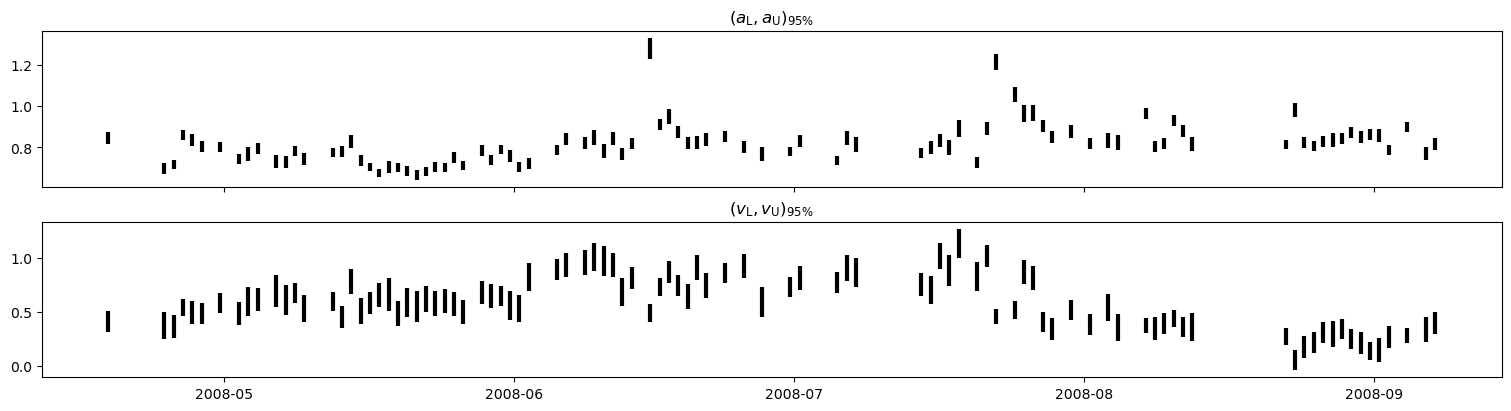

In [10]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 4), layout="constrained", sharex=True)

axs[0].set_title(r"$(a_\text{L}, a_\text{U})_{95\%}$")
axs[0].vlines(df_fit_ddm.index, df_fit_ddm["a-"], df_fit_ddm["a+"], color="k", lw=3)

axs[1].set_title(r"$(v_\text{L}, v_\text{U})_{95\%}$")
axs[1].vlines(df_fit_ddm.index, df_fit_ddm["v-"], df_fit_ddm["v+"], color="k", lw=3)